## CapsNet MNIST

This is an implementation of Geoffrey Hinton's CapsNet architecture as described in [Sabour 2017]. The implementation is (very) insipired by Aurélien Géron's implementation and is for learning purposes only.

## Setup

In [16]:
# Imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from datetime import datetime

import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import layers
import losses
from utils import batch, norm
from data import mnist

In [18]:
# TensorBoard logging
ROOT_LOGDIR = "tf_logs"

def log_run():
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}".format(ROOT_LOGDIR, now)
    
    return logdir

In [19]:
# Stabilize ouptut accross runs
# TODO give the caller more control over what to reset

def reset(seed=42):
    tf.reset_default_graph()
    np.random.seed(seed)
    tf.set_random_seed(42)
    
reset()

## MNIST Dataset

In [20]:
(X_train, y_train), (X_val, y_val), (X_test, y_test)= mnist.load_data()

In [21]:
max_elem = X_train.max()
min_elem = X_train.min()

X_train = (X_train - min_elem)/(max_elem - min_elem)
X_val = (X_val - min_elem)/(max_elem - min_elem)
X_test = (X_test - min_elem)/(max_elem - min_elem)

In [22]:
def peek_data(n_samples=5):
    plt.figure(figsize=(n_samples * 2, 3))
    
    for index in range(n_samples):
        plt.subplot(1, n_samples, index + 1)
        
        # images are stored as flattened numpy arrays
        sample_image = X_train[index].reshape(28, 28)
        
        plt.imshow(sample_image, cmap="binary")
        plt.axis("off")
    
    plt.show()
    
    
def peek_labels(n_samples=5):
    print(y_train[:n_samples])

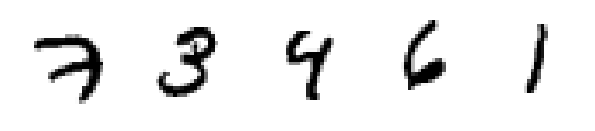

In [23]:
peek_data()

In [24]:
peek_labels()

[7 3 4 6 1]


## CapsNet model

In [25]:
tf.reset_default_graph()

## Inputs

X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")
y_one_hot = tf.one_hot(y, depth=10, name="y_one_hot")
## Model

conv1 = tf.layers.conv2d(
    X, 
    filters=256,
    kernel_size=9,
    strides=1,
    padding="valid",
    name="conv1"
)

primaryCaps = layers.primaryCaps(
    conv1, 
    caps=32, 
    dims=8,
    kernel_size=9,
    strides=2,
    name="primaryCaps"
)

digitCaps = layers.denseCaps(
    primaryCaps, 
    caps=10, 
    dims=16
)


probabilities = norm(digitCaps, axis=-1, name="probabilities")
margin_loss = losses.margin_loss(y_one_hot, probabilities, name="margin_loss")


predictions = tf.argmax(probabilities, axis=-1, name="predictions")
with tf.variable_scope("accuracy"):
    correct = tf.equal(y, predictions, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    

with tf.variable_scope("reconstructions"):
    mask_with_labels = tf.placeholder_with_default(False, shape=(), name="mask_with_labels")

    reconstruction_targets = tf.cond(mask_with_labels,
                                     lambda: y,
                                     lambda: predictions,
                                     name="reconstruction_targets")

    reconstructions = layers.denseDecoder(digitCaps, reconstruction_targets, [512, 1024, 28*28], name="reconstructions")
    
reconstruction_loss = losses.reconstruction_loss(X, reconstructions, name='reconstruction_loss')

alpha = tf.constant(0.0005, name='alpha')
loss = margin_loss + alpha * reconstruction_loss

train_margin_loss_summary = tf.summary.scalar('train_margin_loss', margin_loss)
train_reconstruction_loss_summary = tf.summary.scalar('train_reconstruction_loss', reconstruction_loss)
train_loss_summrary = tf.summary.scalar('train_loss', loss)
train_accuracy = tf.summary.scalar('train_accuracy', accuracy)
train_summaries = tf.summary.merge(
    [train_margin_loss_summary, train_reconstruction_loss_summary, train_loss_summrary, train_accuracy]
)

val_margin_loss_summary = tf.summary.scalar('val_margin_loss', margin_loss)
val_reconstruction_loss_summary = tf.summary.scalar('val_reconstruction_loss', reconstruction_loss)
val_loss_summrary = tf.summary.scalar('val_loss', loss)
val_accuracy = tf.summary.scalar('val_accuracy', accuracy)
val_summaries = tf.summary.merge(
    [val_margin_loss_summary, val_reconstruction_loss_summary, val_loss_summrary, val_accuracy]
)

In [26]:
logdir = log_run()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

optimizer = tf.train.AdamOptimizer()
train_op  = optimizer.minimize(loss, name="training_op")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

num_epochs = 2
batch_size = 24
checkpoint_path = "./capsnet_mnist_save"


train_iterations_per_epoch = len(X_train) // batch_size
val_iterations_per_epoch = len(X_val) // batch_size

best_val_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(num_epochs):
        print('[Epoch {}/{}]'.format(epoch + 1, num_epochs))
        
        # TRAIN
        train_losses = []
        train_accuracies = []
        
        for iteration, (X_batch, y_batch) in enumerate(batch(X_train, y_train, batch_size=batch_size)):
            
            train_op.run(
                feed_dict={
                    X: X_batch.reshape([-1, 28, 28, 1]),
                    y: y_batch.reshape([-1]),
                    mask_with_labels: True
                }
            )
            
            train_loss, train_accuracy = sess.run(
                [loss, accuracy],
                feed_dict={
                    X: X_batch.reshape([-1, 28, 28, 1]),
                    y: y_batch.reshape([-1]),
                    mask_with_labels: True
                }
            )
        
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
        
            if (iteration + 1) % 10 == 0:
                print('\rTrain | Iteration {}/{} ({:.1f}%) | Batch Accuracy: {:.4f}% Loss: {:.6f}'.format(
                    iteration + 1,
                    train_iterations_per_epoch,
                    (iteration + 1) * 100 / train_iterations_per_epoch,
                    train_accuracy * 100,
                    train_loss
                ), 
                end="")
                
                train_summary_str = train_summaries.eval(
                    feed_dict={
                        X: X_batch.reshape([-1, 28, 28, 1]),
                        y: y_batch.reshape([-1])
                    }
                )
                
                file_writer.add_summary(train_summary_str, epoch * train_iterations_per_epoch + iteration)
            
        avg_train_loss = np.mean(train_losses)
        avg_train_accuracy = np.mean(train_accuracies)
        
        print('\rTrain | Average Accuracy: {:.4f}% Loss: {:.6f}'.format(
            avg_train_accuracy * 100,
            avg_train_loss), 
        end=" " * 30 + "\n")
                
        
        # VALIDATE
        val_losses = []
        val_accuracies = []
        
        for iteration, (X_batch, y_batch) in enumerate(batch(X_val, y_val, batch_size=batch_size)):
            
            val_loss, val_accuracy = sess.run(
                [loss, accuracy],
                feed_dict={
                    X: X_batch.reshape([-1, 28, 28, 1]),
                    y: y_batch.reshape([-1]),
                }
            )
            
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            if (iteration + 1) % 5 == 0:
                print('\rValidation | Iteration {}/{} ({:.1f}%) | Batch Accuracy: {:.4f}% Loss: {:.6f}'.format(
                    iteration + 1,
                    val_iterations_per_epoch,
                    (iteration + 1) * 100 / val_iterations_per_epoch,
                    val_accuracy * 100,
                    val_loss
                ), 
                end="")
            
         
                val_summary_str = val_summaries.eval(
                    feed_dict={
                        X: X_batch.reshape([-1, 28, 28, 1]), 
                        y: y_batch.reshape([-1])
                    }
                )
                file_writer.add_summary(val_summary_str, epoch * val_iterations_per_epoch + iteration)
            

        avg_val_loss = np.mean(val_losses)
        avg_val_accuracy = np.mean(val_accuracies)
        
        print('\rValidation | Average Accuracy: {:.4f}% Loss: {:.6f}'.format(
            avg_val_accuracy * 100,
            avg_val_loss), 
        end=" " * 30 + "\n")

        if avg_val_loss < best_val_loss:
            saver.save(sess, checkpoint_path)
            best_val_loss = avg_val_loss

[Epoch 1/2]
Train | Average Accuracy: 97.2949% Loss: 0.042551                              
Validation | Iteration 205/208 (98.6%) | Batch Accuracy: 100.0000% Loss: 0.028537HERE
Validation | Average Accuracy: 97.0295% Loss: 0.042334                              
[Epoch 2/2]
Train | Average Accuracy: 98.3766% Loss: 0.026235                              
Validation | Iteration 205/208 (98.6%) | Batch Accuracy: 100.0000% Loss: 0.025990HERE
Validation | Average Accuracy: 97.2687% Loss: 0.039177                              


In [13]:
# TEST

test_iterations = len(X_test) // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    test_losses = []
    test_accuracies = []
    
    for iteration, (X_batch, y_batch) in enumerate(batch(X_test, y_test, batch_size)):
        
        test_loss, test_accuracy = sess.run(
            [loss, accuracy],
            feed_dict={
                X: X_batch.reshape([-1, 28, 28, 1]),
                y: y_batch.reshape([-1]),
            },
        )
        
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print("\rEvaluation | Iteration {}/{} ({:.1f}%)".format(
            iteration + 1, 
            test_iterations, 
            (iteration + 1) * 100/test_iterations),
             end=" " * 30
        )
        
    avg_test_loss = np.mean(test_losses)
    avg_test_accuracy = np.mean(test_accuracies)
    
    print("\rEvaluation | Accuracy: {:.4f}% Loss: {:.6f}".format(avg_test_accuracy * 100, avg_test_loss))

INFO:tensorflow:Restoring parameters from ./capsnet_mnist_save
Evaluation | Accuracy: 90.8973% Loss: 0.113210                       


In [14]:
# Predictions

n_samples = 2

sample_images = X_train[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    digitCaps_output, reconstructions_output, predictions_output = sess.run(
        [digitCaps, reconstructions, predictions],
        feed_dict={
            X: sample_images,
            y: np.array([], dtype=np.int64) # will not be used
        },
    )

INFO:tensorflow:Restoring parameters from ./capsnet_mnist_save


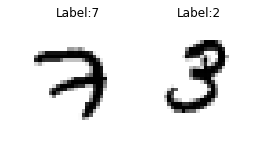

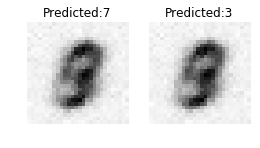

In [15]:
sample_images = sample_images.reshape([-1, 28, 28])
reconstructions_output = reconstructions_output.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(y_test[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(reconstructions_output[index], cmap="binary")
    plt.title("Predicted:" + str(predictions_output[index]))
    plt.axis("off")